# Analysis of Money Supply in the United States
Money supply in the United States is made up of the following money aggregates:

Type of money | MB | M1 | M2 | M3
--- | --- | --- | --- | ---
Currency in circulation | ✓ | ✓ | ✓ | ✓
Reserve balances (Federal Reserve Bank credit) | ✓ |  |   |  
Demand deposits and other liquid deposits consisting of OCDs and savings deposits |  | ✓ | ✓ | ✓ 
Small-denomination<sup>1</sup> time deposits and balances in retail MMFs (less IRA and Keogh balances) |  |  | ✓ | ✓
Large time deposits and institutional money market funds, short-term repurchase aggrements |  |  |  | ✓

As you can see from the above table, `MB` currency in circulation < `M1` < `M2` < `M3` as each of the larger money supply aggregates includes the preceeding one. The _monetary base_ (MB) aggregates are also referred to as _central bank money_ as they are claims on the central bank that issues the currency. The components of `M1` and `M2` on the other hand are claims on regulated banks that holds the corresponding accounts. Each aggregate is meant to be convertable to a lower aggregate without any loss to the notional. For `M1` and `M2` the guarantee is provided by the FDIC for amounts less than or equal to \$250,000.00 per depositor (on top of required regulatory capital and liquidity ratios that banks keep and report to the regulators). The higher the aggregate the longer the conversion to a lower candidate can take. For `M3` the situations where the corresponding money market fund "broke the buck", i.e. an investment of \$1 became less than 1 are few and far in between.

Since the Board of Governors of the Federal Reserve System [ceased publication of the M3 monetary aggregate and its components in 2006](https://www.federalreserve.gov/releases/h6/discm3.htm), in this notebook I analyze the development of each of the aggregates of US money supply except for M3. I use both nominal and real measures by adjusting for CPI.

[1] in amounts of less than $100,000.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()

### Preparing factors for conversion from nominal to real amounts by adjusing for monthly CPI

In [3]:
nom_2_real_conv_factors = web.get_data_fred('CPIAUCSL', start=report_start, end=report_end)
nom_2_real_conv_factors['conv_factor'] = nom_2_real_conv_factors.CPIAUCSL.iloc[-1] / nom_2_real_conv_factors.CPIAUCSL

# Convert into pandas.Series
nom_2_real_conv_factors = nom_2_real_conv_factors.conv_factor

## Analysis of annual changes in the main components of M2
It's interesting to see how different components of M2 change over time, this allows us to gain insights into whether it is the Fed Reserve that is increasing money supply or commercial banks' credit. I deliberately make use of **not seasonally adjusted** series and look at both nominal as well as **real (i.e. inflation-adjusted)** money supply.

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/) for this analysis:
* `MBCURRCIR` &mdash; Monetary Base; Currency in Circulation in millions of Dollars, not seasonally adjusted (monthly frequency)
* `M1NS` &mdash; M1 in billions of Dollars, not seasonally adjusted (monthly frequency)
* `M2NS` &mdash; M2 in billions of Dollars, not seasonally adjusted (monthly frequency)

By definition `MBCURRCIR` < `M1NS` < `M2NS` as each of the larger money supplies includes the preceeding one. For this analysis I subtract the smaller money supply aggregates from larger ones to only look at the additional parts they add on top of their smaller counterparts. After this adjustement the following holds: `M2NS` = `M2_add_on` + `M1_add_on` + `MBCURRCIR_add_on`.

Due to changes in the methodology of how M1 and M2 are calculated that the Fed Reserve introduced in May 2020, the analysis is only meaningful from that date.

For stacked visualizing of total M2 money supply and its constituent components I produce two graphs &mdash; one based on the nominal and the other on the real money supply. I convert from the nominal to real money supply by adjusting for CPI using this data series:
* `CPIAUCSL` &mdash;  Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (monthly frequency)

In [4]:
report_start = date(2020, month=5, day=1)

In [5]:
m2_components = web.get_data_fred(['MBCURRCIR', 'M1NS', 'M2NS'], start=report_start, end=report_end)

m2_total = m2_components.M2NS.copy()
m2_total.rename('M2 Total', inplace=True)

# Converting into billions of USD
m2_components.MBCURRCIR /= 1000.

# Subtracting smaller money aggregates from larger ones so that we have only additional parts contributed
# by each of the larger aggregates left
m2_components.M2NS -= m2_components.M1NS
m2_components.M1NS -= m2_components.MBCURRCIR

In [6]:
M2_COMPOSITION_TITLE = 'Composition of US M2 Money Supply'
REALM2_COMPOSITION_TITLE = 'Composition of US Real M2 Money Supply'
IN_USD_FORMATER = ' in {:%Y-%m} USD'
LEFT_Y_AXIS_LABEL = 'Billions of USD'
m2_components.rename(
    columns={'MBCURRCIR': 'MB Currency in Circulation', 'M1NS': 'M1 Add-ons', 'M2NS': 'M2 Add-ons'},
    inplace=True)
pd.options.display.float_format = None
pd.concat([m2_total, m2_components], axis=1).tail(12)

,M2 Total,MB Currency in Circulation,M1 Add-ons,M2 Add-ons
DATE,,,,
2022-12-01,21433.3,2298.7,17581.0,1553.6
2023-01-01,21290.1,2299.1,17286.3,1704.7
2023-02-01,21136.3,2299.8,17016.7,1819.8
2023-03-01,21042.1,2313.1,16763.9,1965.1
2023-04-01,20859.0,2323.7,16420.0,2115.3
2023-05-01,20728.4,2334.0,16157.8,2236.6
2023-06-01,20767.4,2342.9,16089.9,2334.6
2023-07-01,20745.3,2339.1,15996.9,2409.3
2023-08-01,20721.2,2331.1,15900.4,2489.7


In [7]:
# Convert from nominal into real money supply
m2real_total = (m2_total * nom_2_real_conv_factors).dropna()
m2real_components = m2_components.copy()
m2real_components = m2real_components.multiply(nom_2_real_conv_factors, axis=0).dropna()

m2real_total.rename('Real M2 Total', inplace=True)
m2real_components.rename(
    columns={'MB Currency in Circulation': 'Real MB Currency in Circulation',
             'M1 Add-ons': 'Real M1 Add-ons', 'M2 Add-ons': 'Real M2 Add-ons'},
    inplace=True)

In [8]:
pd.concat([m2real_total, m2real_components], axis=1).tail(18)

,Real M2 Total,Real MB Currency in Circulation,Real M1 Add-ons,Real M2 Add-ons
DATE,,,,
2022-06-01,22543.400839,2379.939897,19079.846517,1083.614426
2022-07-01,22551.470361,2381.270227,19025.706376,1144.493757
2022-08-01,22471.831039,2373.396543,18891.977904,1206.456592
2022-09-01,22299.188837,2366.859030,18658.042976,1274.286830
2022-10-01,22101.551845,2360.627767,18367.223682,1373.700396
2022-11-01,22069.217115,2364.665780,18224.044309,1480.507026
2022-12-01,22073.238022,2367.332713,18105.919185,1599.986124
2023-01-01,21812.973227,2355.564640,17710.842086,1746.566501
2023-02-01,21575.565186,2347.595597,17370.349593,1857.619996


### Visualization of US  Nominal M2 Money Supply

#### Stacked Visualization Amounting to Total US M2 Money Supply

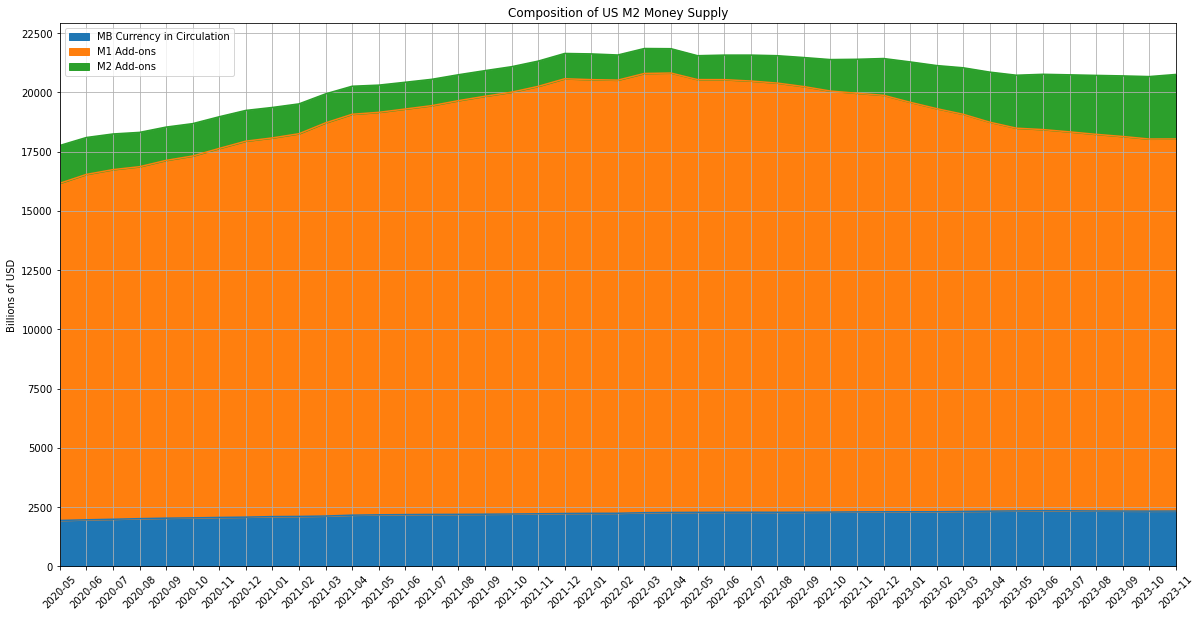

In [9]:
ax = m2_components.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                          xticks=m2_components.index, xlabel='', rot=45,
                          ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components.index)))

In [10]:
idxmax = m2_total.idxmax()
print('Nominal M2 money supply maximum of {:>8.2f}bn reached in month {:%Y-%m}'
      .format(m2_total.loc[idxmax], idxmax))
print('Nominal M2 money supply shrank by  {:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m2_total.iloc[-1]-m2_total.loc[idxmax], m2_total.index[-1]))
print('Nominal M2 money supply changed by  {:>8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(m2_total.iloc[-1]-m2_total.iloc[-2], m2_total.index[-2], m2_total.iloc[-1]))

Nominal M2 money supply maximum of 21856.00bn reached in month 2022-03
Nominal M2 money supply shrank by  -1095.80bn since (as of month 2023-11)
Nominal M2 money supply changed by     89.10bn since 2023-10 to 20760.20bn


In [11]:
m2_components.iloc[-1,:] - m2_components.iloc[-2,:]

MB Currency in Circulation     3.1
M1 Add-ons                    -0.1
M2 Add-ons                    86.1
dtype: float64

#### Visualization as Percent of Total US M2 Money Supply

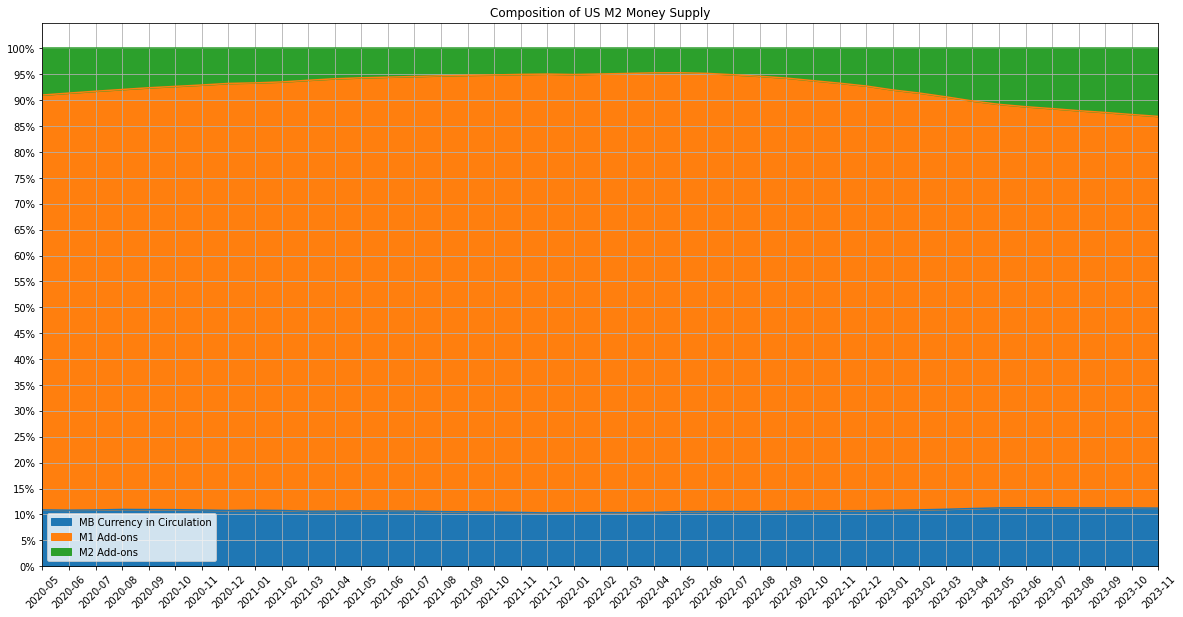

In [12]:
# Converting to percentages by dividing by total M2 Money Supply.
# Dividing by the total M2 Money Supply
m2_components_pct = m2_components.divide(m2_total, axis=0)
m2_components_pct *= 100

ax = m2_components_pct.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                              xticks=m2_components_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components_pct.index)))

In [13]:
m2_components_pct.iloc[-1,:] - m2_components_pct.iloc[-2,:]

MB Currency in Circulation   -0.033339
M1 Add-ons                   -0.326642
M2 Add-ons                    0.359981
dtype: float64

In [14]:
m2_components_pct.iloc[-1,:]

MB Currency in Circulation    11.213765
M1 Add-ons                    75.668346
M2 Add-ons                    13.117889
Name: 2023-11-01 00:00:00, dtype: float64

### Visualization of US Real M2 Money Supply

#### Stacked Visualization Amounting to Total US Real M2 Money Supply

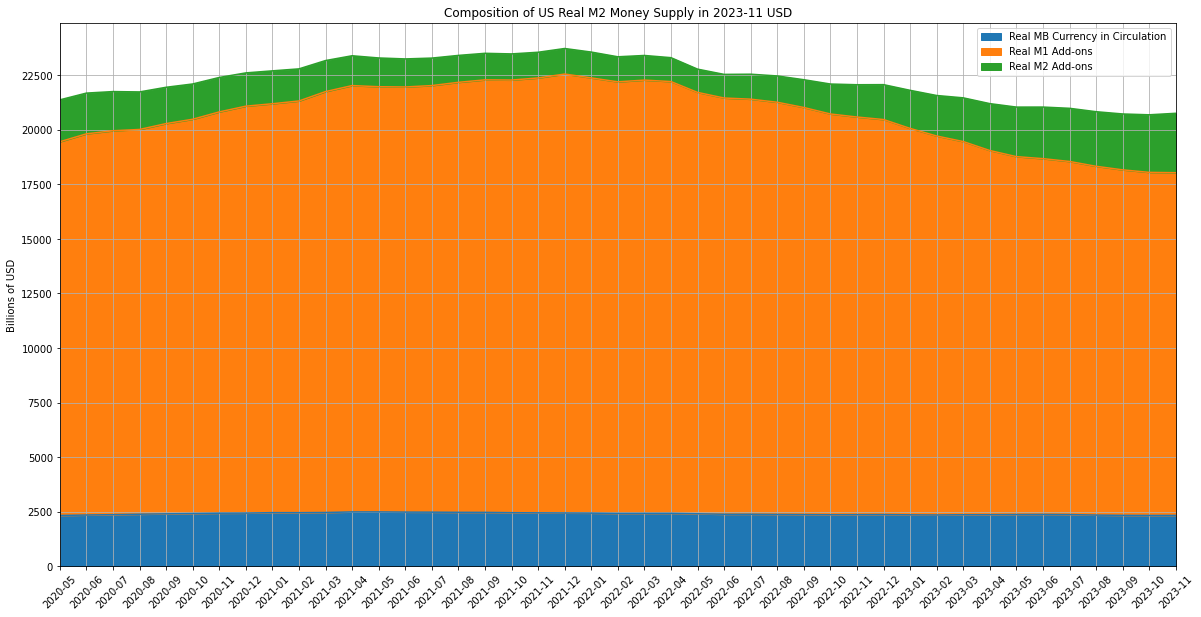

In [15]:
ax = m2real_components.plot.area(
                figsize=(20,10), grid=True,
                title=REALM2_COMPOSITION_TITLE + IN_USD_FORMATER.format(m2real_components.index[-1].date()),
                xticks=m2_components.index, xlabel='', rot=45,
                ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2real_components.index)))

In [16]:
idxmax = m2real_total.idxmax()
print('Real M2 money supply maximum of {:>8.2f}bn reached in month {:%Y-%m}'
      .format(m2real_total.loc[idxmax], idxmax))
print('Real M2 money supply shrank by  {:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m2real_total.iloc[-1]-m2real_total.loc[idxmax], m2real_total.index[-1]))
print('Real M2 money supply shrank by  {:>8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(m2real_total.iloc[-1]-m2real_total.iloc[-2], m2real_total.index[-2], m2real_total.iloc[-1]))

Real M2 money supply maximum of 23729.78bn reached in month 2021-12
Real M2 money supply shrank by  -2969.58bn since (as of month 2023-11)
Real M2 money supply shrank by     69.08bn since 2023-10 to 20760.20bn


In [17]:
m2real_components.iloc[-1,:] - m2real_components.iloc[-2,:]

Real MB Currency in Circulation     0.847798
Real M1 Add-ons                   -15.317792
Real M2 Add-ons                    83.545263
dtype: float64

#### Visualization as Percent of Total US Real M2 Money Supply

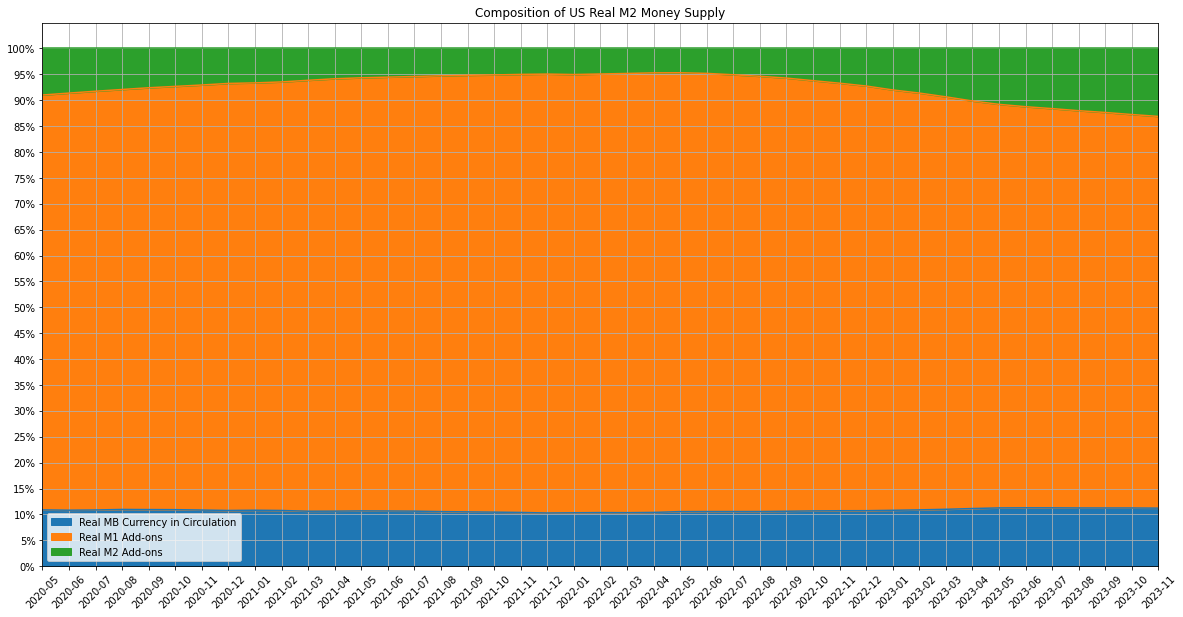

In [18]:
# Converting to percentages by dividing by total M2 Money Supply.
# Dividing by the total M2 Money Supply
m2real_components_pct = m2real_components.divide(m2real_total, axis=0)
m2real_components_pct *= 100

ax = m2real_components_pct.plot.area(figsize=(20,10), grid=True, title=REALM2_COMPOSITION_TITLE,
                              xticks=m2real_components_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2real_components_pct.index)))

### Visualizing Annual Percentage Changes in the Main Components of US M2 Money Supply

In [19]:
m2_components_speed = (m2_components - m2_components.shift(1)).dropna()

In [20]:
# Converting to annual percentage changes (changes from the corresponding quarter a year ago)
m2_annual_rate = pd.concat([m2_total, m2_components], axis=1).pct_change(12)
m2_annual_rate = m2_annual_rate.loc['2021-05':]

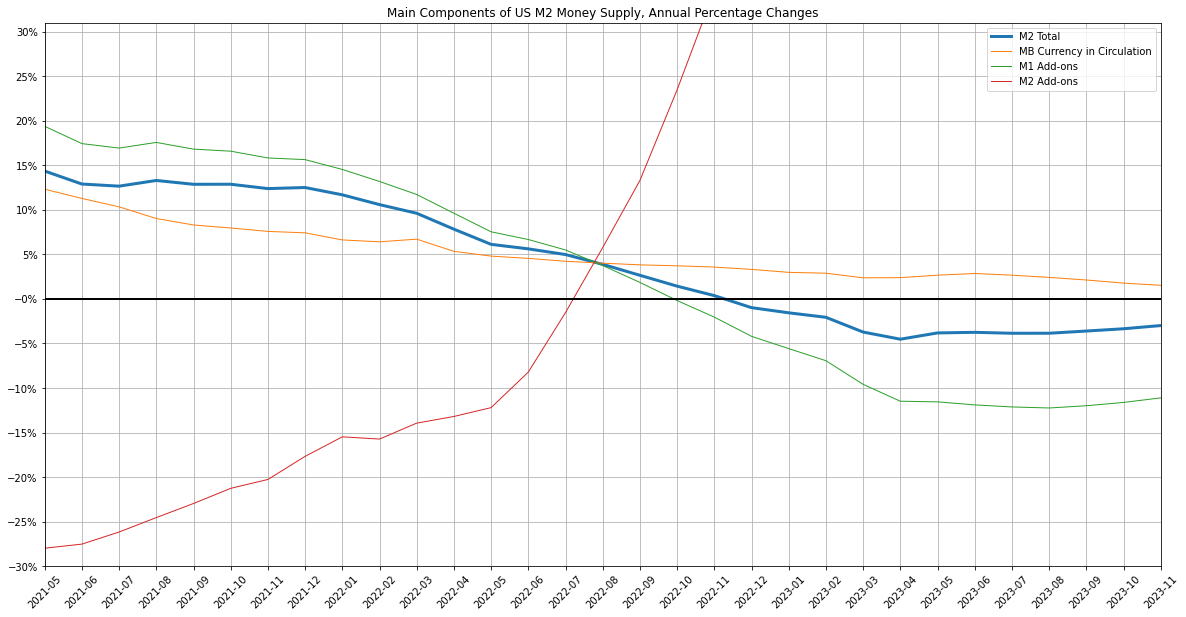

In [21]:
ax = m2_annual_rate.iloc[:,:1].plot(figsize=(20,10), grid=True,
                        title='Main Components of US M2 Money Supply, Annual Percentage Changes',
                        xticks=m2_annual_rate.index, xlabel='', rot=45, ylim=(-.3,.31),yticks=np.arange(-.30, 0.31, .05),
                        linewidth=3)
m2_annual_rate.iloc[:,1:].plot(ax=ax, grid=True, xticks=m2_annual_rate.index, xlabel='', rot=45, linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_annual_rate.index)))

In [22]:
pd.options.display.float_format = (lambda x: '{:.3%}'.format(x) if x < 100 else '{:,.0f}bn'.format(x))
m2_annual_rate.tail(12)

,M2 Total,MB Currency in Circulation,M1 Add-ons,M2 Add-ons
DATE,,,,
2022-12-01,-0.986%,3.308%,-4.204%,45.332%
2023-01-01,-1.566%,2.974%,-5.583%,56.740%
2023-02-01,-2.068%,2.881%,-6.937%,71.324%
2023-03-01,-3.724%,2.363%,-9.591%,86.424%
2023-04-01,-4.527%,2.379%,-11.484%,105.768%
2023-05-01,-3.822%,2.657%,-11.558%,121.599%
2023-06-01,-3.756%,2.849%,-11.897%,125.087%
2023-07-01,-3.860%,2.660%,-12.127%,120.007%
2023-08-01,-3.857%,2.407%,-12.245%,115.167%


### Visualizing monthly and arbitrary term changes in the components of M2

In [23]:
M2_COMPONENTS_SPEED = 'Speed of changes in US M2 Money Supply in Billions of USD per month'
M2_COMPONENTS_CHANGES = 'Changes in Components of US M2 Money Supply in Billions of USD'
M2REAL_COMPONENTS_SPEED = 'Speed of changes in US Real M2 Money Supply in Billions of USD per month'
M2REAL_COMPONENTS_CHANGES = 'Changes in Components of US Real M2 Money Supply in Billions of USD'
LEFT_Y_AXIS_LABEL = 'Billions of USD'

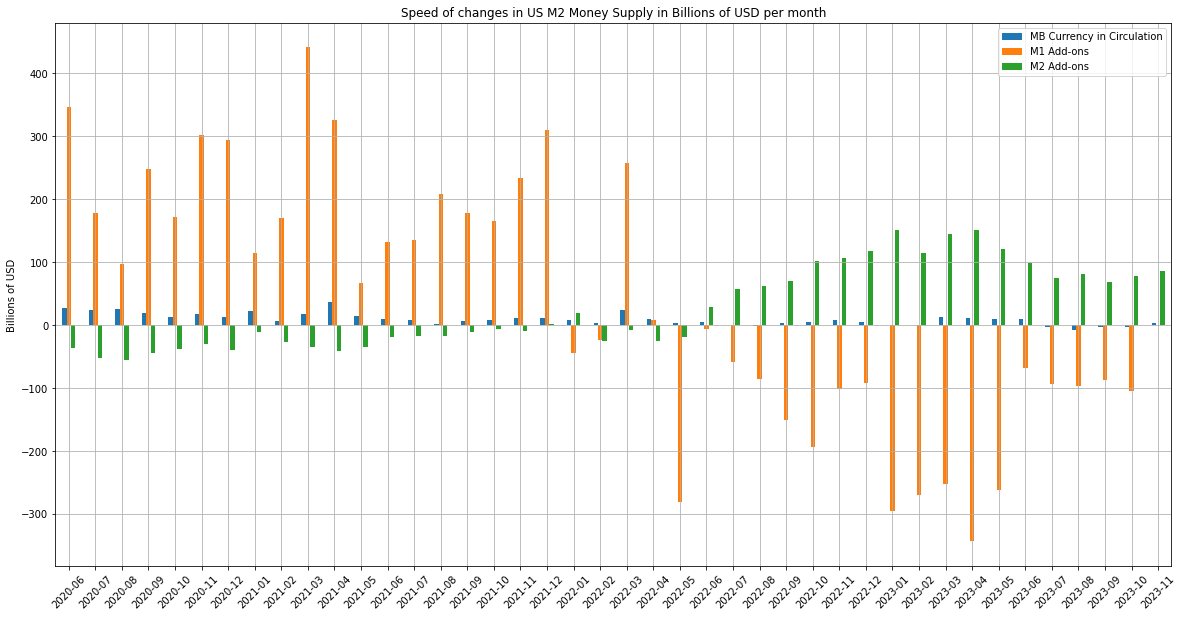

In [24]:
ax = m2_components_speed.iloc[:,:].plot.bar(figsize=(20,10), grid=True,
                            title=M2_COMPONENTS_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components_speed.index)))

Having looked at monthly changes, let's have a look at how the composition of money supply has changed over longer intervals such as 12 and 18 months.

In [25]:
# In months
periods = [12, 18]

In [26]:
# If you want to include currency in circulation, use iloc[-1] in the expression below
m2_df_comp_changes = pd.DataFrame([(m2_components - m2_components.shift(period)).iloc[-1, 1:] for period in periods], 
                                  index=['Over past {:d} month'.format(period) for period in periods])

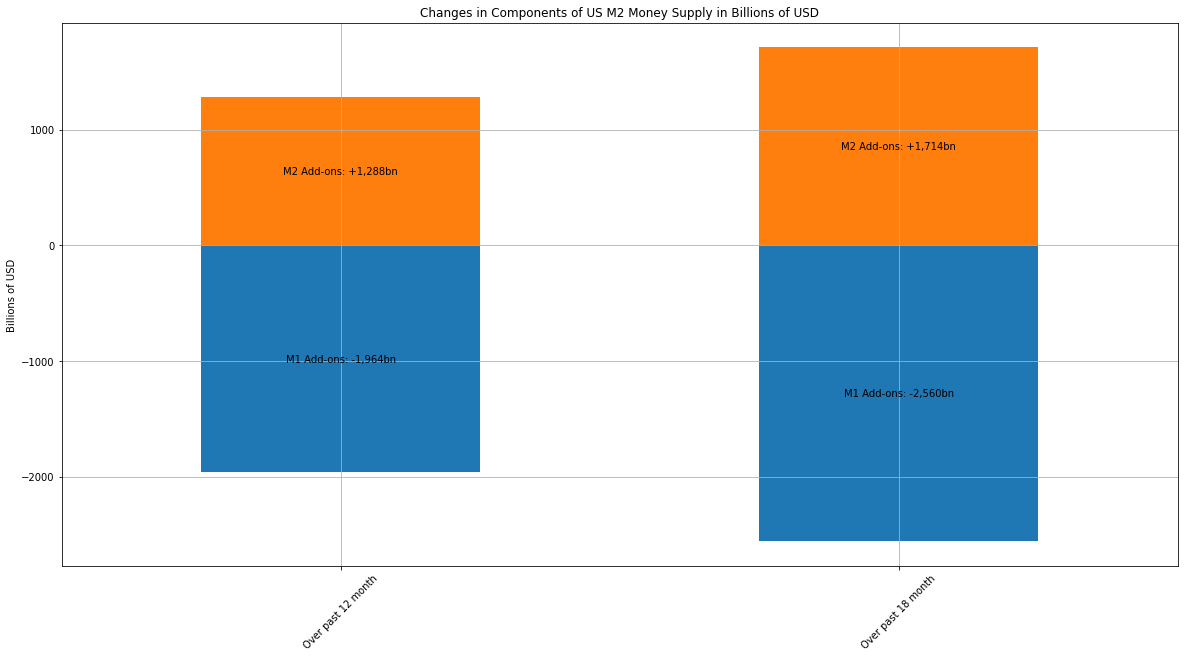

In [27]:
ax = m2_df_comp_changes.plot.bar(figsize=(20,10), grid=True, title=M2_COMPONENTS_CHANGES,
                                 stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+,.0f}bn', label_type='center')

### Visualizing Annual Percentage Changes in the Main Components of US Real M2 Money Supply

In [28]:
m2real_components_speed = (m2real_components - m2real_components.shift(1)).dropna()

In [29]:
# Converting to annual percentage changes (changes from the corresponding quarter a year ago)
m2real_annual_rate = pd.concat([m2real_total, m2real_components], axis=1).pct_change(12)
m2real_annual_rate = m2real_annual_rate.loc['2021-05':]

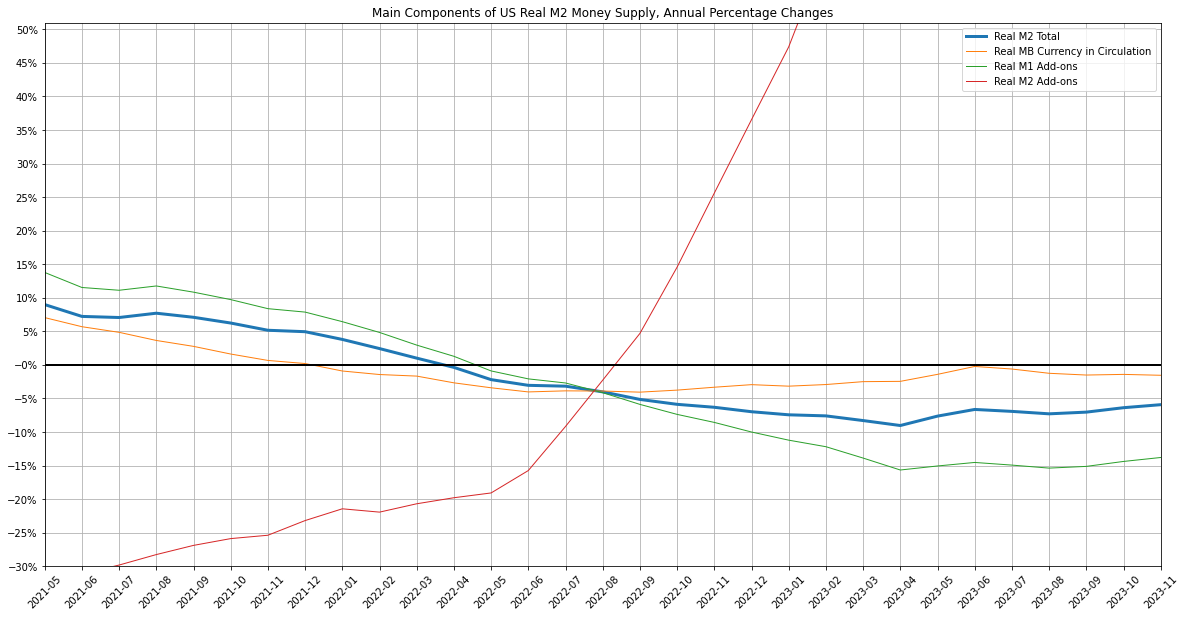

In [30]:
ax = m2real_annual_rate.iloc[:,:1].plot(figsize=(20,10), grid=True,
                            title='Main Components of US Real M2 Money Supply, Annual Percentage Changes',
                            xticks=m2real_annual_rate.index, xlabel='', rot=45,
                            ylim=(-.3,.51), yticks=np.arange(-.3, .51, .05),
                            linewidth=3)
m2real_annual_rate.iloc[:,1:].plot(ax=ax, grid=True, xticks=m2real_annual_rate.index, xlabel='', rot=45, linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2real_annual_rate.index)))

In [31]:
m2real_annual_rate.tail(12)

,Real M2 Total,Real MB Currency in Circulation,Real M1 Add-ons,Real M2 Add-ons
DATE,,,,
2022-12-01,-6.981%,-2.947%,-10.004%,36.533%
2023-01-01,-7.440%,-3.172%,-11.218%,47.385%
2023-02-01,-7.600%,-2.930%,-12.193%,61.647%
2023-03-01,-8.297%,-2.499%,-13.885%,77.569%
2023-04-01,-9.036%,-2.456%,-15.665%,96.050%
2023-05-01,-7.636%,-1.414%,-15.064%,112.812%
2023-06-01,-6.642%,-0.236%,-14.539%,118.336%
2023-07-01,-6.930%,-0.619%,-14.934%,112.981%
2023-08-01,-7.294%,-1.254%,-15.382%,107.475%


### Visualizing monthly and arbitrary term changes in the components of Real M2

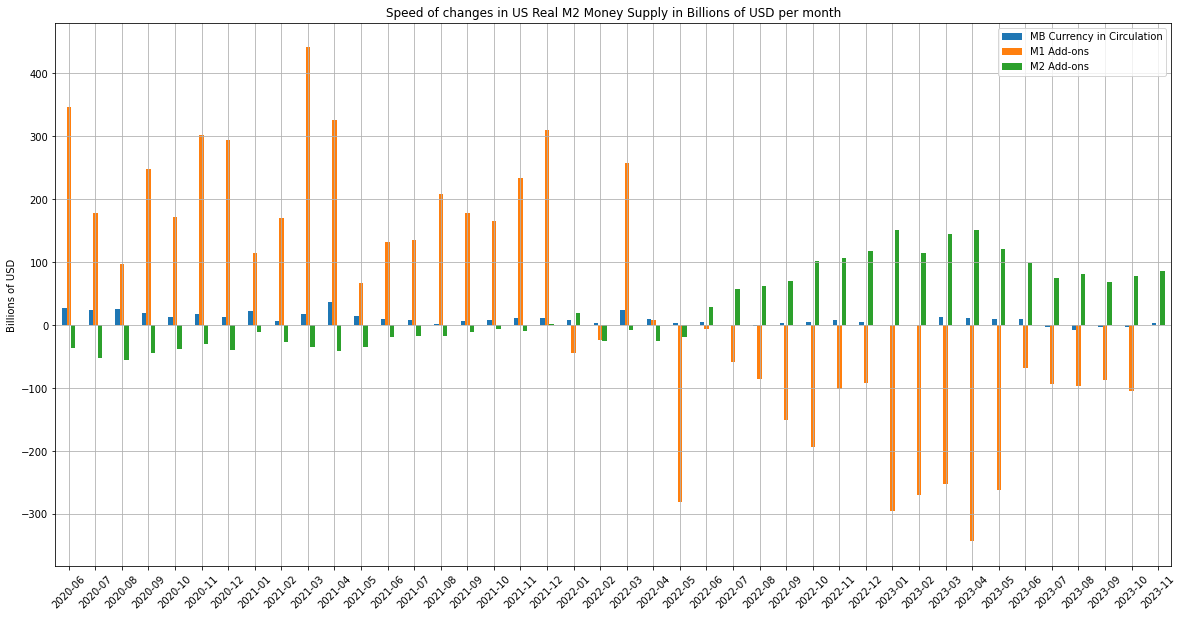

In [32]:
ax = m2_components_speed.iloc[:,:].plot.bar(figsize=(20,10), grid=True,
                            title=M2REAL_COMPONENTS_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components_speed.index)))

In [33]:
# If you want to include currency in circulation, use iloc[-1] in the expression below
m2real_df_comp_changes = pd.DataFrame([(m2real_components - m2real_components.shift(period)).iloc[-1, 1:] for period in periods], 
                                  index=['Over past {:d} month'.format(period) for period in periods])

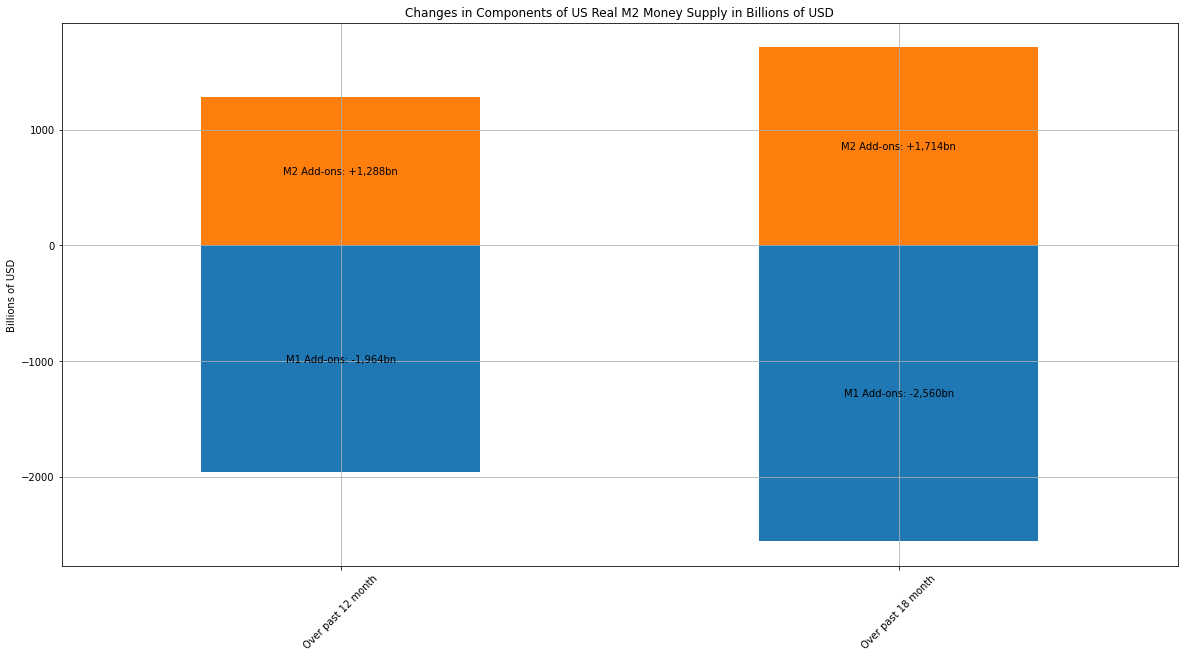

In [34]:
ax = m2_df_comp_changes.plot.bar(figsize=(20,10), grid=True, title=M2REAL_COMPONENTS_CHANGES,
                                 stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+,.0f}bn', label_type='center')

## Analysis of the Reserve Balances' component of Monetary Base
Monetary base is money that the central bank (the FED in the case of the US) produces. It consists of:
* **Currency in circulation** (USD banknotes and coins in circulation domestically and abroad), which is a component of M1/M2 broad money supply that I looked at earlier in this notebook
* **Reserve balances** &mdash; electronic central bank money that banks and financial institutions that have a license to operate in the US hold in a reserve account directly at a Federal Reserve Bank. In this part of the notebook I analyze the development of reserve balances.

In the past the so-called _fractional reserve banking_ requirement stipulated that commercial banks needed to reserve a certain percentage of customer deposits as reserve at the central bank. The reserve requirement applied only to transactional deposits and used to be 10% a decade ago. As of March 26th 2020 the requirement was abolished by the FED. In the days when it was active it was meant to limit M1 money supply from commercial banks. To see how it worked is easy with an example. I will stick with a 10% reserve requirement for the purposes of illustrating the point. A `$100` deposit leads to a maximum `$90` of lending (given that 10% of `$100` must be reserved at a central bank account), which leads to a further `$90` of deposits in the banking system, which leads to a maximum of further `$81` of lending, etc. As this process continues, the total money supply (M1) that's created is 90 + 81 + 72.9 + ... = `$900`. If a resere requirement were 20%, a `$100` deposit would lead to maxumum of `$400` lending in the banking system.

Anyway, with the reserve requirement abolished, why do banks and other FIs still hold trillions of dollars on the reserve balances? Most likely this has to do with daily RTGS payment volumes (≈ $2tn) and Basel III's Net Stable Funding Ratio, which doesn't require funding for cash held at a federal reserve bank . Whereas most other banks' assets do call for reserving Tier 1/Tier 2 capital.

Another factor affecting reserve balances is Basel III _leverage ratio_. It's a Basel III requirement for banks to hold at least 3\% of Tier 1 equity capital for their total exposure. The total exposure includes on-balance-sheet as well as off-balance-sheet items. Logically a given bank's reserves at a federal reserve bank, as well as its treasury securities holdings, count towards the bank's leverage ratio, requiring it to increase their Tier 1 capital for increases in their central bank reserves or trasury securities holdings. In the US the regulator requires systemically important banks to adhere to a leverage ratio of 5\%. On 1<sup>st</sup> April 2020 (more or less at the same time when fractional reserve banking requirements were abolished for US banks) [the FED temporarily excluded reserve balances and treasury securities from leverage ratio calculations](https://www.federalreserve.gov/newsevents/pressreleases/bcreg20200401a.htm). The relaxation was in place for one year till 31<sup>st</sup> 2021. It's not surprising that reserve balances grew during that time frame.

Finally, the quantitative tighting that the FED started in June 2022 contributes to reserve balances declining. This is because when a treasury security or mortgage bond on the FED's balance matures, the FED closes the reserve balance it create when purchasing it during quantittative easing. You can see more details of this process [in this Jupyter notebook](../Quantitative_Easing_and_Tapering.ipynb).

Given that the Fed compensates banks with an interest on resrve balances, in the below analysis I also look at it as it has a material bearing on banks' liquidity management processes.

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/) for this analysis:
* `BOGMBBM` &mdash; Monetary Base; Reserve Balances in millions of Dollars, not seasonally adjusted (monthly frequency). Unfortunately this series is always approximately a month late, so I approximate the latest month value with the some of `TERMT` and `WLODLL` series.
* `IORR` &mdash; Interest Rate on Required Reserves (DISCONTINUED from July 29, 2021 and replaced by the interest rate on reserve balances, see the bullet below) (daily frequency)
* `IORB` &mdash; Interest Rate on Reserve Balances (daily frequency)
* `GS1M` &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (monthly frequency). I use it to calculate the difference between the interest the Fed pays banks on reserve balances and the yield they can alternatively obtain by investing in short-term treasuries.

In [35]:
report_start = date(2008, month=10, day=1)
mbase_reserves = web.get_data_fred(['BOGMBBM', 'GS1M'], start=report_start, end=report_end)

# Converting reserves balances into billions of USD
mbase_reserves.BOGMBBM /= 1000.

# Converting 1-month treasury yields into percentage points
mbase_reserves.GS1M /= 100.

iorr = web.get_data_fred('IORR', start=report_start, end=report_end).resample('MS').mean() / 100.
iorb = web.get_data_fred('IORB', start=report_start, end=report_end).resample('MS').mean() / 100.
iorb = pd.concat([iorr.IORR, iorb.IORB])

In [36]:
# Approximate the latest value of Reserve Balances 
reserve_balances = web.get_data_fred(['TERMT', 'WLODLL'], start=report_start, end=report_end).asfreq('W-Wed')
reserve_balances = reserve_balances.sum(axis=1).resample('MS').mean() / 1000.
reserve_balances.rename('BOGMBBM', inplace=True)
idx = reserve_balances.index.difference(mbase_reserves.BOGMBBM.dropna().index)

# Approximate the latest value of 1-month treasury securities
latest_1m_tr_yield = web.get_data_fred('DGS1MO', start=report_start, end=report_end).DGS1MO / 100.
latest_1m_tr_yield = latest_1m_tr_yield.resample('MS').mean()
latest_1m_tr_yield.rename('GS1M', inplace=True)

# First update the missing values in mbase_reserves dataframe
mbase_reserves.update(pd.concat([reserve_balances[idx], latest_1m_tr_yield[idx]], axis=1))     

# Now append the missing rows if any
idx = reserve_balances.index.difference(mbase_reserves.index)
mbase_reserves = pd.concat([mbase_reserves, pd.concat([reserve_balances[idx], latest_1m_tr_yield[idx]], axis=1)])

In [37]:
irt_reserves = pd.concat([mbase_reserves.iloc[:,0:], mbase_reserves.BOGMBBM * nom_2_real_conv_factors,
                          iorb, iorb-mbase_reserves.iloc[:,1]], axis=1)#.dropna()
irt_reserves.rename(
    columns={'BOGMBBM': 'MB Reserve Balances', 0:'MB Real Reserve Balances',
             1: 'Interest Rate on Reserve Balances',
             2: 'Interest on Reserve Balances-1m Treasury yield',},
    inplace=True)

In [38]:
irt_reserves

,MB Reserve Balances,GS1M,MB Real Reserve Balances,Interest Rate on Reserve Balances,Interest on Reserve Balances-1m Treasury yield
DATE,,,,,
2008-10-01,285bn,0.290%,404bn,1.335%,1.045%
2008-11-01,577bn,0.090%,833bn,0.983%,0.893%
2008-12-01,788bn,0.030%,"1,148bn",0.613%,0.583%
2009-01-01,825bn,0.050%,"1,199bn",0.250%,0.200%
2009-02-01,667bn,0.220%,965bn,0.250%,0.030%
...,...,...,...,...,...
2023-08-01,"3,228bn",5.540%,"3,245bn",5.400%,-0.140%
2023-09-01,"3,240bn",5.530%,"3,244bn",5.400%,-0.130%
2023-10-01,"3,276bn",5.570%,"3,280bn",5.400%,-0.170%


### Visualizing the development of Reserve Balances and Interest paid on them
I look at both nominal reserve balances as well as real (i.e. adjusted for CPI).

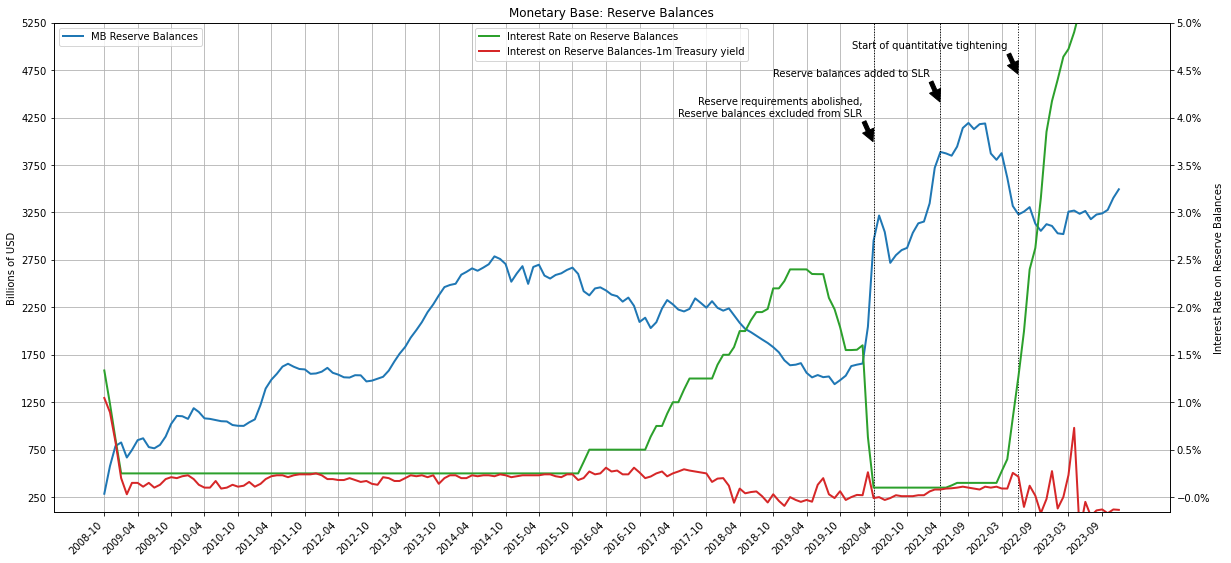

In [39]:
LEFT_Y_AXIS_LABEL = 'Billions of USD'
RIGHT_Y_AXIS_LABEL = 'Interest Rate on Reserve Balances'
RESERVE_REQ_ABOLISH_DATE = '2020-04-01'
SLR_REINTRODUCTION_DATE = '2021-04-01'
QUANTITATIVE_TIGHTENING_DATE = '2022-06-01'
#ax = irt_reserves.iloc[:,[0,2]].plot(figsize=(20,10), grid=True,
ax = irt_reserves.iloc[:,:1].plot(figsize=(20,10), grid=True,
                     title='Monetary Base: Reserve Balances', ylabel=LEFT_Y_AXIS_LABEL,
                     xticks=irt_reserves.index[::6], xlabel='', rot=45, linewidth=2,
                     yticks=np.arange(250, 5251, 500))
#ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '%.0f' % x)))
ax.axvline(irt_reserves.index[irt_reserves.index.get_loc(RESERVE_REQ_ABOLISH_DATE)], color='k',
           linestyle=':', linewidth=1)
ax.axvline(irt_reserves.index[irt_reserves.index.get_loc(SLR_REINTRODUCTION_DATE)], color='k',
           linestyle=':', linewidth=1)
ax.axvline(irt_reserves.index[irt_reserves.index.get_loc(QUANTITATIVE_TIGHTENING_DATE)], color='k',
           linestyle=':', linewidth=1)
x1 = irt_reserves.index[irt_reserves.index.get_loc(RESERVE_REQ_ABOLISH_DATE)]
y1 = irt_reserves.iloc[:,0].max() * .95
x2 = irt_reserves.index[irt_reserves.index.get_loc(RESERVE_REQ_ABOLISH_DATE) - 2]
y2 = y1 + irt_reserves.iloc[:,0].max() / 15
ax.annotate('Reserve requirements abolished,\nReserve balances excluded from SLR',
            xy=(x1, y1), xytext=(x2, y2), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

x1_ = irt_reserves.index[irt_reserves.index.get_loc(SLR_REINTRODUCTION_DATE)]
y1_ = irt_reserves.iloc[:,0].max() * 1.05
x2_ = irt_reserves.index[irt_reserves.index.get_loc(SLR_REINTRODUCTION_DATE) - 2]
y2_ = y1_ + irt_reserves.iloc[:,0].max() / 15
ax.annotate('Reserve balances added to SLR',
            xy=(x1_, y1_), xytext=(x2_, y2_), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

x1__ = irt_reserves.index[irt_reserves.index.get_loc(QUANTITATIVE_TIGHTENING_DATE)]
y1__ = irt_reserves.iloc[:,0].max() * 1.12
x2__ = irt_reserves.index[irt_reserves.index.get_loc(QUANTITATIVE_TIGHTENING_DATE) - 2]
y2__ = y1__ + irt_reserves.iloc[:,0].max() / 15
ax.annotate('Start of quantitative tightening',
            xy=(x1__, y1__), xytext=(x2__, y2__), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

_ = ax.legend(loc='upper left')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = irt_reserves.iloc[:,3:].plot(ax=ax2, linewidth=2, linestyle='-', ylabel=RIGHT_Y_AXIS_LABEL,
     xticks=irt_reserves.index[::6], color=['#2ca02c','#d62728'], ylim=(-.0016, .05), yticks=np.arange(-.0, .051, .005))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.set_xticklabels(list(map('{:%Y-%m}'.format, irt_reserves.index[::6])))
_ = ax2.legend(loc='upper center')

In [40]:
idxmax_res = irt_reserves.iloc[:,0].idxmax()
idxmax_real_res = irt_reserves.iloc[:,2].idxmax()
print('Real Reserves maximum of     {:>8.2f}bn reached in month {:%Y-%m}'
      .format(irt_reserves.loc[idxmax_real_res].iloc[2], idxmax_real_res))
print('Nominal Reserves maximum of  {:>8.2f}bn reached in month {:%Y-%m}'
      .format(irt_reserves.loc[idxmax_res].iloc[0], idxmax_res))
print('Real Reserves changed by     {:>+8.2f}bn since (as of month {:%Y-%m})'
      .format(irt_reserves.iloc[-1,2]-irt_reserves.loc[idxmax_real_res].iloc[2], irt_reserves.index[-1]))
print('Nominal Reserves changed by  {:>+8.2f}bn since (as of month {:%Y-%m})'
      .format(irt_reserves.iloc[-1,0]-irt_reserves.loc[idxmax_res].iloc[0], irt_reserves.index[-1]))
print('Real Reserves changed by     {:>+8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(irt_reserves.iloc[-1,2]-irt_reserves.iloc[-2,2], irt_reserves.index[-2], irt_reserves.iloc[-1,2]))
print('Nominal Reserves changed by  {:>+8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(irt_reserves.iloc[-1,0]-irt_reserves.iloc[-2,0], irt_reserves.index[-2], irt_reserves.iloc[-1,0]))

Real Reserves maximum of      4711.77bn reached in month 2021-09
Nominal Reserves maximum of   4193.20bn reached in month 2021-09
Real Reserves changed by         +nanbn since (as of month 2023-12)
Nominal Reserves changed by   -699.19bn since (as of month 2023-12)
Real Reserves changed by         +nanbn since 2023-11 to nanbn
Nominal Reserves changed by    +90.61bn since 2023-11 to 3494.01bn


#### What's the ratio of reserves balances to total M2 money supply?

In [41]:
m2_total = web.get_data_fred('M2NS', start=irt_reserves.index[0]).M2NS

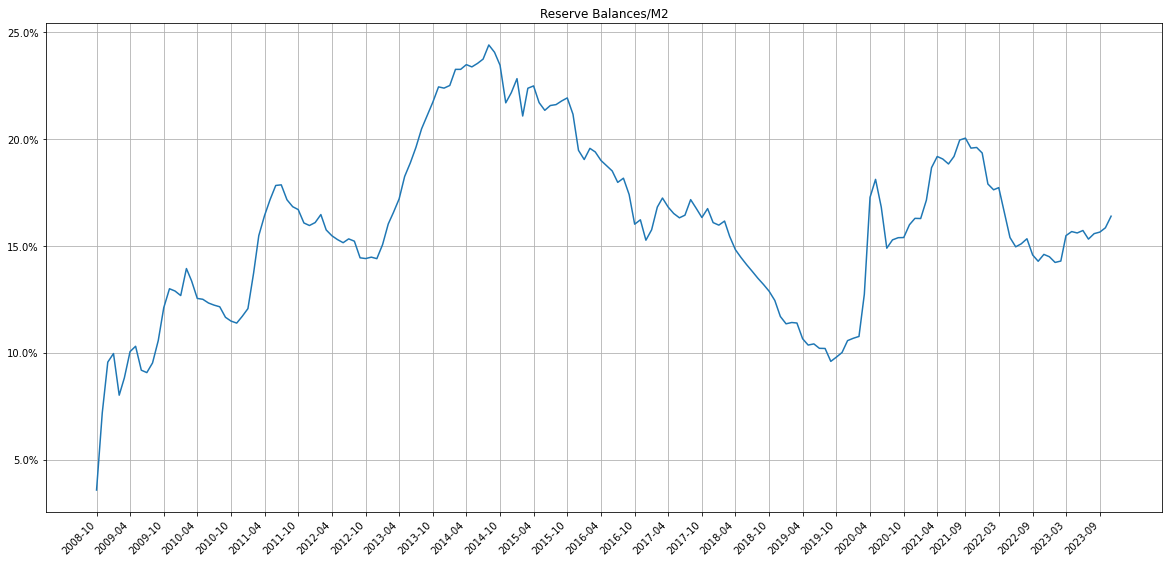

In [42]:
ax = (irt_reserves.iloc[:, 0] / m2_total).plot(figsize=(20,10), grid=True,
                     title='Reserve Balances/M2', 
                     xticks=irt_reserves.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, irt_reserves.index[::6])))